# **Import dependesies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
from matplotlib import pyplot as plt

# **Databse path**

In [ ]:
!unzip '/content/drive/MyDrive/apple-20240519T191040Z-001.zip'

In [3]:
data_dir='/content/drive/MyDrive/apple/'

# **load Data and labels**

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,labels="inferred", image_size=(227, 227))


Found 4645 files belonging to 4 classes.


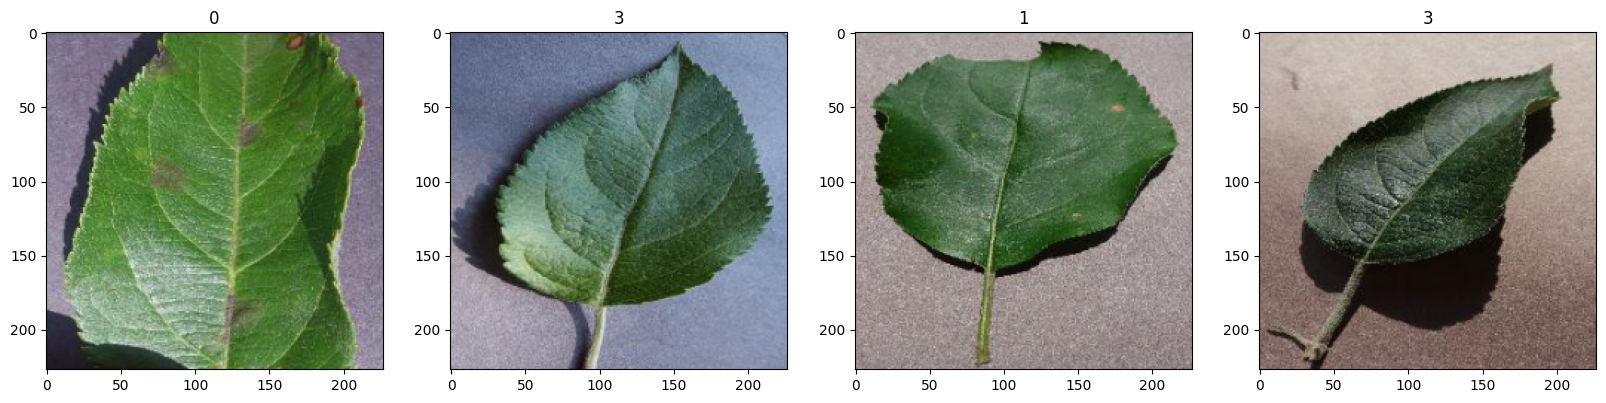

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
class_names = data.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


# **specific the size of data type**

In [6]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

# **data partitioning**

In [7]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train_labels = []
train_files=[]
for i, label in train.unbatch():
    train_labels.append(label)
    train_files.append(i)
train_labels = tf.stack(train_labels, axis=0)
#train_files=np.array([train_files])
train_labels=np.asarray(train_labels).astype('float32').reshape((-1,1))
#print(train_files[:30])

In [ ]:
val_labels = []
val_files=[]
for i, label in val.unbatch():
    val_labels.append(label)
    val_files.append(i)
val_labels = tf.stack(val_labels, axis=0)
#val_files=np.array([val_files])
val_labels=np.asarray(val_labels).astype('float32').reshape((-1,1))
#print(val_labels)

In [38]:
test_labels = []
#test_files=[]
for i, label in test.unbatch():
    test_labels.append(label)
    #test_files.append(i)
test_labels = tf.stack(test_labels, axis=0)
test_labels=np.asarray(test_labels).astype('float32').reshape((-1,1))

In [8]:
def to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

train_images, train_labels = to_numpy(train)
val_images, val_labels = to_numpy(val)
test_images, test_labels = to_numpy(test)

# **create model**

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
#Alexnet model
def AlexNet(dropout_rate=0.5):
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(4, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizer method for estimating the loss function
  opt = SGD(learning_rate = 0.001)
  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = opt,
                metrics = ['accuracy'])

  return model


# **Resnet model**

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [11]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=len(class_names), dropout_rate=0.5):
    # بارگذاری مدل ResNet50 بدون لایه‌های بالایی (top layers)
    base_model = ResNet50(include_top=False, input_shape=input_shape)

    # فریز کردن مدل پایه
    base_model.trainable = False

    # ساخت مدل جدید روی مدل پایه
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),  # افزودن یک لایه Dropout
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # کامپایل کردن مدل
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

# **Densenet model**

In [12]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

In [13]:
def dense_block(x, num_filters, num_layers, dropout_rate=0.2):
    for i in range(num_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(y)
        y = Dropout(dropout_rate)(y)  # افزودن لایه Dropout
        x = tf.keras.layers.concatenate([x, y])
    return x

# تعریف لایه انتقالی (Transition Layer)
def transition_layer(x, num_filters, dropout_rate=0.2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    return x

# ایجاد مدل DenseNet
def create_densenet_model(input_shape=(224, 224, 3), num_classes=len(class_names), num_dense_blocks=3, num_layers_per_block=4, growth_rate=12, dropout_rate=0.2):
    input = tf.keras.layers.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    num_filters = 64
    for i in range(num_dense_blocks):
        x = dense_block(x, growth_rate, num_layers_per_block, dropout_rate)
        num_filters += num_layers_per_block * growth_rate
        if i != num_dense_blocks - 1:
            x = transition_layer(x, num_filters // 2, dropout_rate)
            num_filters = num_filters // 2

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)  # افزودن یک لایه Dropout
    output = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input, outputs=output)

    # کامپایل کردن مدل
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [14]:
model = AlexNet()
model2=create_resnet_model()
model3=create_densenet_model()

# **show model layers**

# **Plot Alexnet**

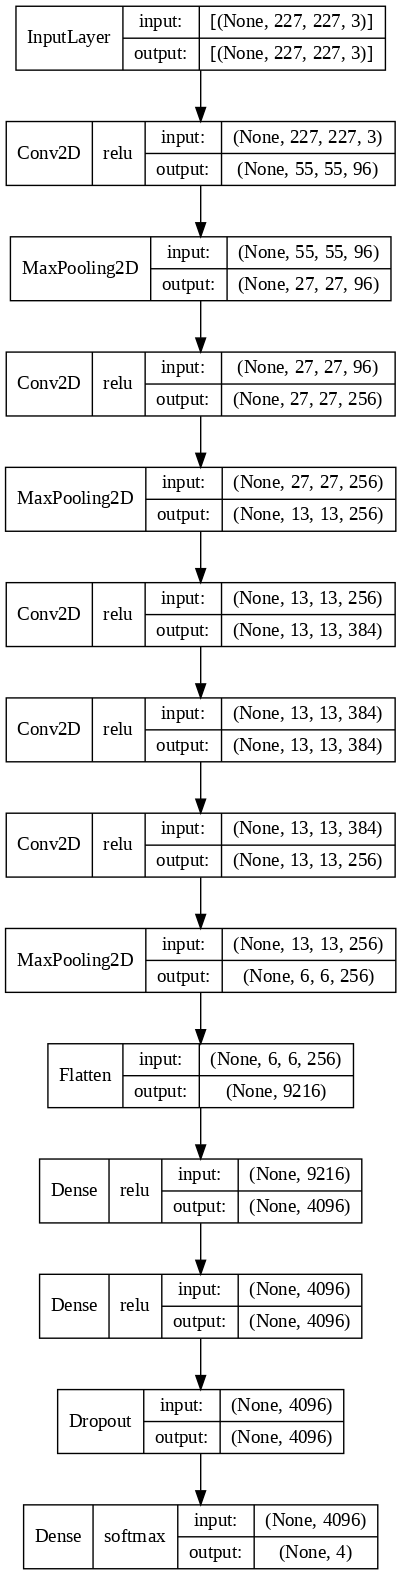

In [19]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

# **plot Resnet**

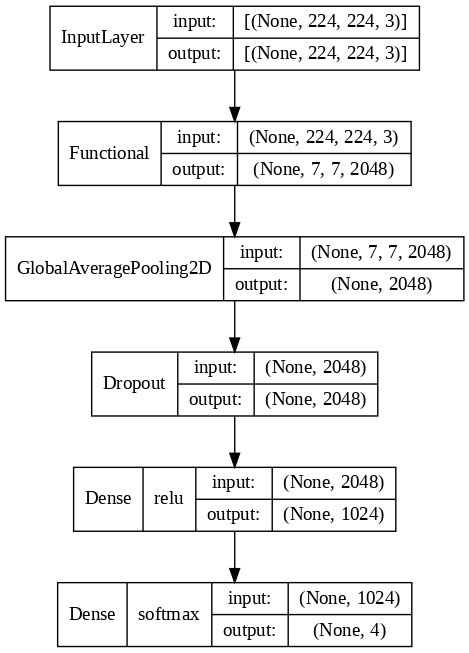

In [20]:
tf.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

# **Plot Densenet**

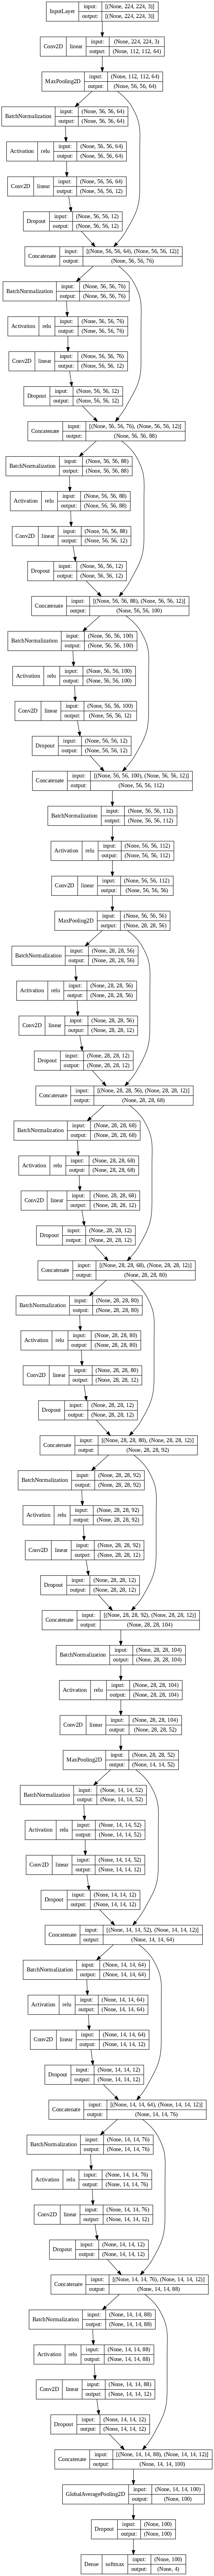

In [21]:
tf.keras.utils.plot_model(
    model3,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

# **compile model**

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5,
                   monitor='loss')

# **train model**

In [ ]:
#history=model.fit(train,batch_size=32, epochs=10, validation_data=val)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))


In [ ]:
model.save_weights('/content/drive/MyDrive/mymodel/alexnet.h5')

In [15]:
model.load_weights('/content/drive/MyDrive/mymodel/alexnet.h5')


In [ ]:
# رسم نمودار دقت
plt.figure(figsize=(12, 5))

# دقت آموزش
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# خطای آموزش
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# نمایش نمودارها
plt.tight_layout()
plt.show()

# **test predictions**

In [35]:
test_predictions = model.predict(test)

14/14 [==============================] - 39s 1s/step


In [16]:
test_predictions = model.predict(test_images)


14/14 [==============================] - 28s 2s/step


In [17]:
test_predictions = np.argmax(test_predictions, axis=1)


In [36]:
test_p=(test_predictions*10).round()


# **Visualization of results**




# **visualization**

1/1 [==============================] - 0s 270ms/step


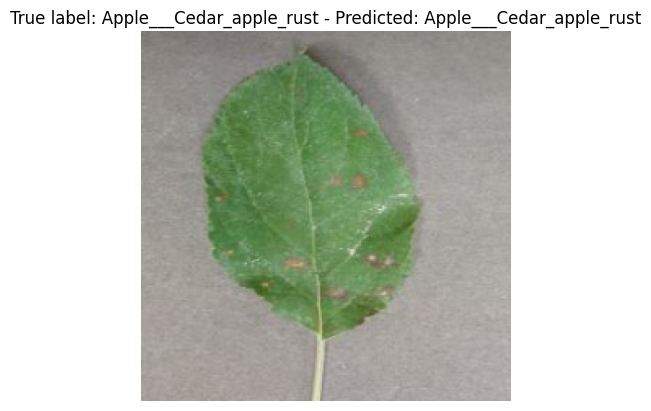

In [22]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# بارگذاری و پیش‌بینی تصویر جدید
image_path = '/content/drive/MyDrive/apple/Apple___Cedar_apple_rust/image (1).JPG'
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)
resized_image = tf.image.resize(image, (227, 227))
normalized_image = tf.cast(resized_image, tf.float32) / 255.0
input_image = tf.expand_dims(normalized_image, axis=0)

# پیش‌بینی کلاس تصویر
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = data.class_names[predicted_class_index]

# نمایش تصویر و نتایج پیش‌بینی
plt.imshow(normalized_image)
plt.title(f'True label: Apple___Cedar_apple_rust - Predicted: {predicted_class}')
plt.axis('off')
plt.show()

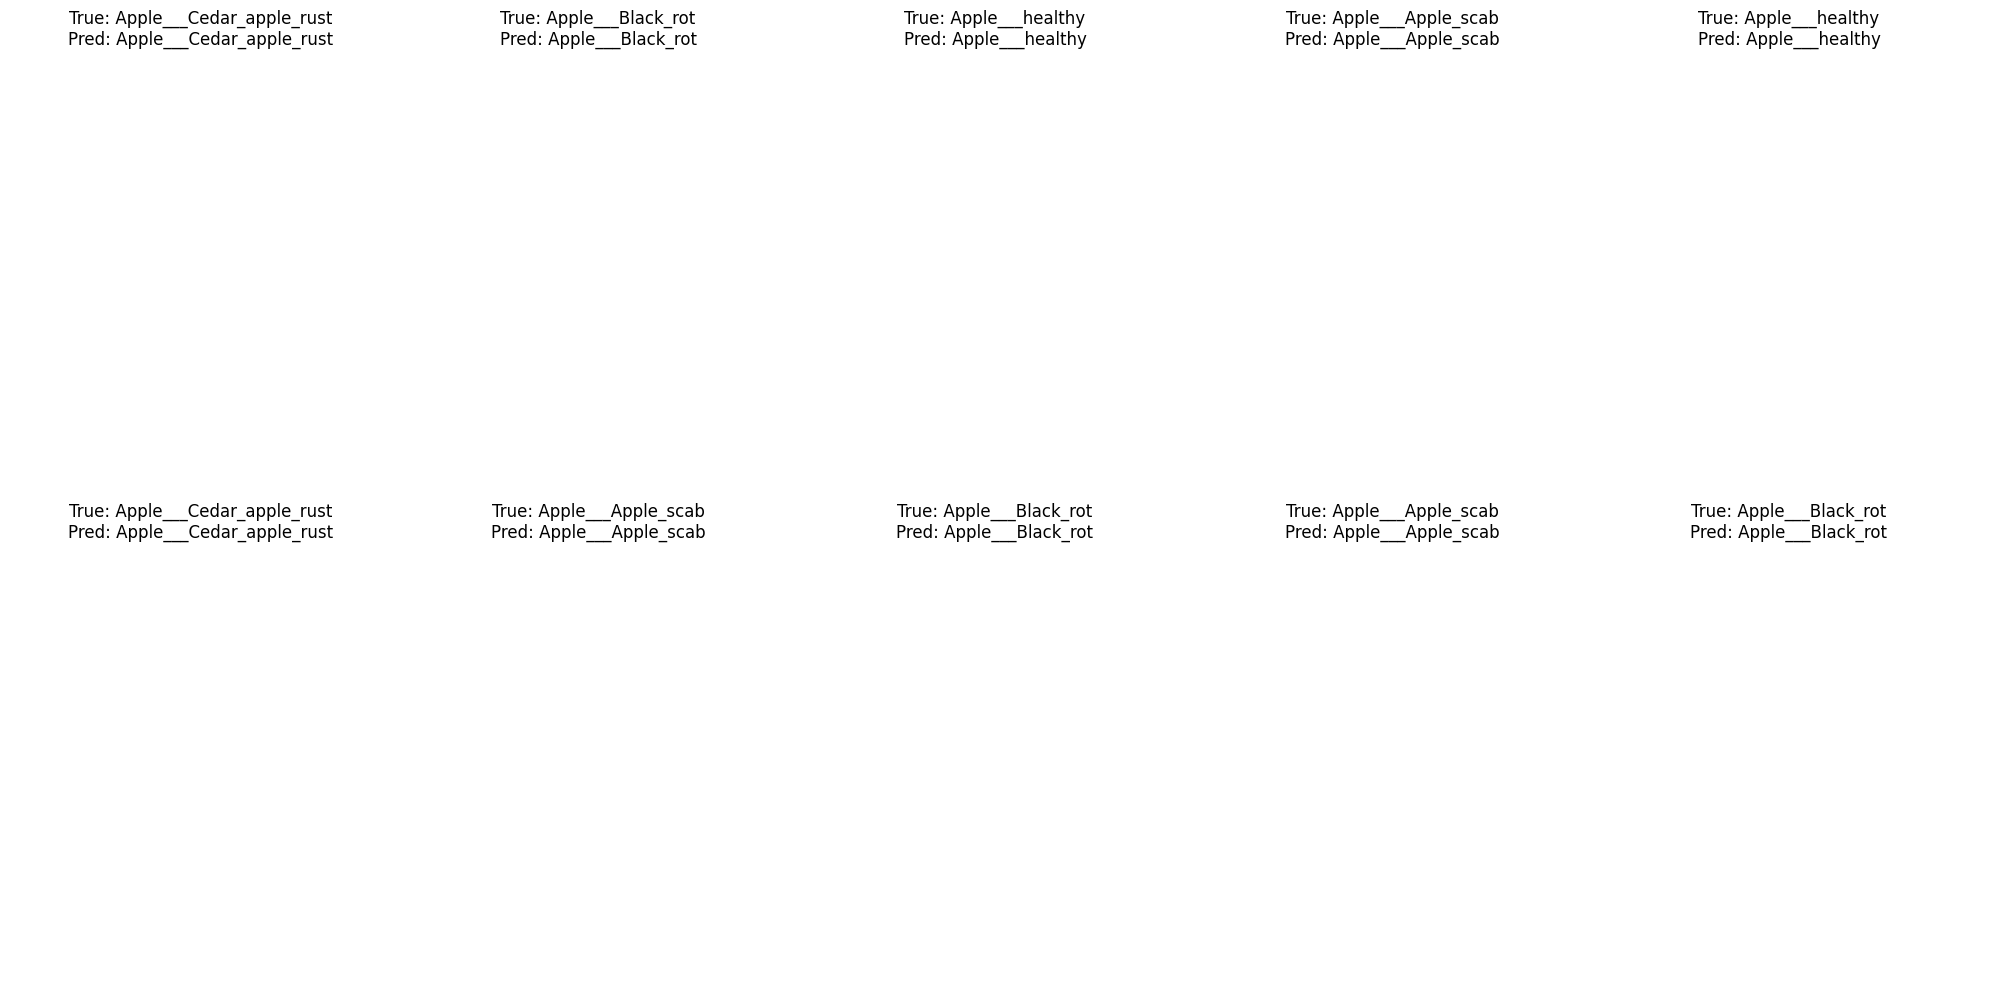

In [30]:
num_samples = 10
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]
sample_predictions = test_predictions[sample_indices]

# تجسم نتایج
plt.figure(figsize=(20, 10))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    #plt.imshow(sample_images[i])
    plt.title(f'True: {data.class_names[sample_labels[i]]}\nPred: {data.class_names[sample_predictions[i]]}')
    plt.axis('off')
plt.tight_layout()
#plt.show()

# **confusion matrix**

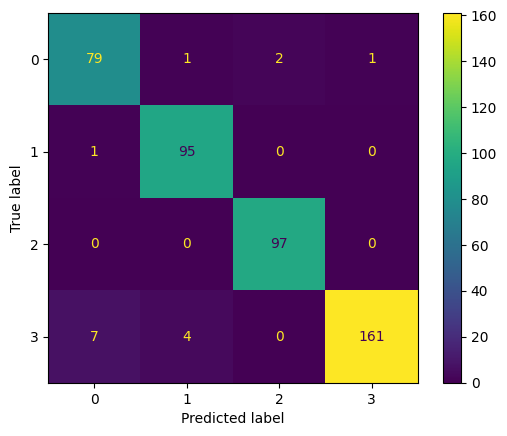

Accuracy: 0.9642857142857143
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        83
           1       0.95      0.99      0.97        96
           2       0.98      1.00      0.99        97
           3       0.99      0.94      0.96       172

    accuracy                           0.96       448
   macro avg       0.96      0.97      0.96       448
weighted avg       0.97      0.96      0.96       448



In [23]:

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay
#predictions = [['0', '1', '2','3'][i] for i in np.argmax(test_p, axis=1)]
#predictions=np.asarray(predictions).astype('float32').reshape((-1,1))
# محاسبه ماتریس درهم‌ریختگی
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
# محاسبه دقت
accuracy = accuracy_score(test_labels,test_predictions)
print("Accuracy:", accuracy)
# گزارش کامل اسکورها (Precision, Recall, F1-Score)
report = classification_report(test_labels,test_predictions)
print("Classification Report:")
print(report)